<a href="https://colab.research.google.com/github/ThiagoPoppe/snare_rythm_transcription/blob/main/tempo_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalando dependências para o projeto
!pip install git+https://github.com/ThiagoPoppe/snare_rythm_transcription.git

  Cloning https://github.com/ThiagoPoppe/snare_rythm_transcription.git to /tmp/pip-req-build-y6xbqp6a
  Running command git clone -q https://github.com/ThiagoPoppe/snare_rythm_transcription.git /tmp/pip-req-build-y6xbqp6a
  Created wheel for snare-rythm-transcription: filename=snare_rythm_transcription-0.1-py3-none-any.whl size=6269 sha256=ce7ab354d278089bcc6d81d560d881b725932975eef5d4d8e68efa8b9c3889b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-hi4bn6ah/wheels/5f/61/77/1d6786fe6d5970ccc00d94354f82d1cacd18758b00c6dbc30e
Successfully built snare-rythm-transcription


# Configuração do ambiente (instalação de outras dependências)

In [2]:
import os
from music21.environment import UserSettings

# Musescore permite com que a gente renderize imagens com as notas musicas do music21
print('installing musescore...')
!apt-get install musescore > /dev/null

# FluidSynth será utilizado para converter midi para .wav (apenas para escutarmos)
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Configurações do virtual framebuffer (necessário para o Google Colab)
!apt-get install xvfb > /dev/null
!sh -e /etc/init.d/x11-common start > /dev/null

os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

# Configurando o path do music21
us = UserSettings()
us['directoryScratch'] = '/tmp'
us['musicxmlPath'] = '/usr/bin/mscore'
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'

print('done!')

installing musescore...
Extracting templates from packages: 100%
installing fluidsynth...
done!


# Unzip dos dados
- Para esse passo, certifique-se que você já incluiu o arquivo `archive.zip` do seguinte [link](https://drive.google.com/file/d/1UlRr061Fiy9kgxMSP_-9QqWN_RirAC7g/view?usp=sharing).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Você pode realizar um mount do seu drive e dar unzip no arquivo
!unzip /content/drive/MyDrive/MIR/snare_rythm_transcription/archive.zip -d /content/ > /dev/null

# Exemplo para vermos se está tudo funcional
- Para esse exemplo, você deveria ser capaz de observar uma partitura de percussão (iniciada com duas barrinhas), com fórmula de compasso 4/4 e BPM = 80. Além disso, deveria ser capaz de ver 6 notas, sendo elas 1 tercina (triplet) e 3 semínimas.

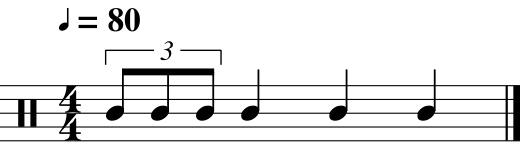

In [5]:
from snare_rythm_transcription.display import play, show
from snare_rythm_transcription.stream import snare_hit, create_percussive_stream

stream = create_percussive_stream(tempo=80, time_signature='4/4')
stream.repeatAppend(snare_hit(time_figure=1/3), 3)
stream.repeatAppend(snare_hit(), 3)

play(stream)
show(stream)

# Funções auxiliares para o ajuste fino dos parâmetros do tempo (bpm)

In [6]:
import librosa
import numpy as np
from bs4 import BeautifulSoup
from snare_rythm_transcription.transcription import transcribe
from snare_rythm_transcription.transcription import create_metronome
from snare_rythm_transcription.transcription import estimate_snare_hit_times

def get_tempo(xml):
    """
        Função que recupera o tempo (BPM) da música em formato musicxml.

        Argumentos:
            - xml (str): nome do musicxml.
        
        Retorno:
            - Um inteiro representando o BPM da música
    """
    with open(xml, 'r') as f:
        sound = BeautifulSoup(f).find('sound')
        tempo = sound.attrs['tempo']

    return int(tempo)

# AQUI ESTÁ A FUNÇÃO A SER TUNADA, MAS NÃO PRECISA MEXER NELA, SÓ NOS KWARGS PASSADOS NA SUA CHAMADA
def estimate_tempo(wave, sr, **kwargs):
    """
        Método para estimar o tempo (BPM) da música utilizando a função
        beat.tempo da biblioteca librosa.
    
        Argumentos:
            - wave (np.array): música na representação vetorial
            - sr (int): taxa de amostragem da música
            - kwargs: outros argumentos para a função librosa.beat.tempo

        Retorno:
            - O valor inteiro do BPM (batidas por minuto).
    """
    tempo = librosa.beat.tempo(wave, sr, **kwargs)
    return int(np.round(tempo))

def transcription_pipeline(wavname, sr=None, tempo=None, time_signature='4/4'):
    """
        Método para transcrever o ritmo da caixa da bateria de um áudio.

        Argumentos:
            - wavname (str): caminho para o arquivo .wav
            - sr (int): taxa de amostragem da música (None -> irá utilizar a taxa original)
            - tempo (int): batidas por minuto da música (None -> irá estimar esse valor)
            - time_signature (str): fórmula de compasso da música, por exemplo "4/4"

        Retorno:
            - Uma Stream do music21 representando a partitura da música transcrita.
    """

    wave, sr = librosa.load(wavname, sr=sr)
    if tempo is None:
        # FUNÇÃO A SER TUNADA (ELA SÓ CHAMA O beat.tempo POR DEBAIXO DOS PANOS)
        # DEPOIS DE AJUSTADO, COLOQUE ESSA FUNÇÃO (transcription_pipeline) NO NOTEBOOK experiments_and_analysis.ipynb
        tempo = estimate_tempo(wave, sr, aggregate=np.median)
    
    snare_times = estimate_snare_hit_times(wave, sr)
    notes_per_measure, reference_note = tuple(map(int, time_signature.split('/')))
    metronome = create_metronome(tempo=tempo, reference_note=reference_note)

    stream = create_percussive_stream(tempo, time_signature)
    for note in transcribe(snare_times, metronome, time_signature):
        stream.append(note)

    return stream

# Carregando dados

In [7]:
# Carregando todos os áudios e musicxmls
import glob
audios = sorted(glob.glob('data/audios/**/*.wav'))
xmls = sorted(glob.glob('data/xmls/**/*.musicxml'))

print(f'Temos {len(audios)} áudios e {len(xmls)} xmls')
print('Primeiro áudio', audios[0])
print('Primeiro xml  ', xmls[0])

Temos 26 áudios e 26 xmls
Primeiro áudio data/audios/compasso_simples/exercicio_em_compasso_simples_#1.wav
Primeiro xml   data/xmls/compasso_simples/exercicio_em_compasso_simples_#1.musicxml
